In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import yaml
import matplotlib.pyplot as plt

def compare_experiments(experiments):
    """
    Compare multiple experiments with train/test metrics.
    
    Args:
        experiments: dict with format {name: (path, color), ...}
    """
    data = {}
    for name, (path, color) in experiments.items():
        with open(f'{path}/train_logs.yaml') as f:
            train = yaml.safe_load(f)
        with open(f'{path}/downstream_results.yaml') as f:
            test = yaml.safe_load(f)
        data[name] = {'train': train, 'test': test, 'color': color}
    
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    
    for name, d in data.items():
        epochs = range(1, len(d['train']['train_loss']) + 1)
        ax0.plot(epochs, d['train']['train_loss'], label=name, color=d['color'], linewidth=2)
    ax0.set_title('Training Loss', fontweight='bold', fontsize=12)
    ax0.set_xlabel('Epoch'); ax0.set_ylabel('Loss')
    ax0.grid(alpha=0.3)
    ax0.legend(loc='upper right', frameon=True, fontsize=9)
    
    ax2 = ax1.twinx()
    for name, d in data.items():
        epochs = range(1, len(d['train']['valid_loss']) + 1)
        ax1.plot(epochs, d['train']['valid_loss'], label=f'{name} (loss)', 
                 color=d['color'], linewidth=2, linestyle='-')
        ax2.plot(epochs, d['train']['valid_metric'], label=f'{name} (metric)', 
                 color=d['color'], linewidth=2, linestyle='--', alpha=0.7)
    
    ax1.set_ylabel('Validation Loss', fontweight='bold')
    ax2.set_ylabel('Validation Metric', fontweight='bold')
    ax1.set_title('Validation Loss & Metric', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Epoch')
    ax1.grid(alpha=0.3)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
               bbox_to_anchor=(1.35, 1), loc='upper left', fontsize=8, frameon=True)
    
    ax3 = fig.add_subplot(gs[1, 0])
    names_list = list(data.keys())
    x = range(len(names_list))
    width = 0.35
    for i, metric in enumerate(['best_val_accuracy', 'test_accuracy']):
        values = [data[name]['test'][metric] for name in names_list]
        ax3.bar([xi + i*width for xi in x], values, width, 
                label=metric.replace('_', ' ').title())
    
    ax3.set_xticks([xi + width/2 for xi in x])
    ax3.set_xticklabels(names_list, rotation=45, ha='right')
    ax3.set_xlabel('Experiment', fontweight='bold')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Test Performance', fontweight='bold', fontsize=12)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    ax3.grid(alpha=0.3, axis='y')
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    table_data = [[name, 
                   f"{data[name]['test']['best_val_accuracy']:.4f}",
                   f"{data[name]['test']['test_accuracy']:.4f}"] 
                  for name in names_list]
    table = ax4.table(cellText=table_data, 
                      colLabels=['Experiment', 'Best Val Acc', 'Test Acc'],
                      cellLoc='center', loc='center',
                      bbox=[0.05, 0.2, 0.9, 0.6])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    for i in range(len(table_data) + 1):
        if i == 0:
            table[(i, 0)].set_facecolor('#CCCCCC')
            table[(i, 1)].set_facecolor('#CCCCCC')
            table[(i, 2)].set_facecolor('#CCCCCC')
        else:
            table[(i, 0)].set_facecolor(data[names_list[i-1]]['color'])
            table[(i, 0)].set_text_props(weight='bold', color='white')
    
    plt.tight_layout()
    plt.show()



# CoLES Experiments

This notebook contains a series of experiments with the CoLES (Contrastive Learning for Event Sequences) model. All experiments can be reproduced using the code in this repository. For detailed setup instructions, please refer to `README.md`.

# Experimental Setup

This notebook follows a two-stage learning pipeline for age prediction on transaction sequences:

## Stage 1: Contrastive Pre-training with CoLES

The CoLES (Contrastive Learning for Event Sequences) model is trained using self-supervised contrastive learning. The training process:

- **Objective**: Learn meaningful sequence representations without labeled data
- **Validation metric**: `recall_top_k` - measures how well the model retrieves similar sequences in the embedding space. This metric calculates the fraction of truly similar sequences that appear among the top-k nearest neighbors of a query sequence.
- **Model selection**: The best epoch is selected based on validation `recall_top_k` performance

The `recall_top_k` metric is crucial for contrastive learning as it directly evaluates whether semantically similar sequences produce nearby embeddings, which is the core objective of the contrastive loss

## Stage 2: Supervised Fine-tuning for Age Prediction

Using the best pre-trained CoLES model from Stage 1:

1. **Extract embeddings**: Generate fixed-length vector representations for all sequences in both train and test sets
2. **Train downstream classifier**: A Multi-Layer Perceptron (MLP) is trained on the extracted embeddings to predict age categories
3. **Evaluation**: Final performance is measured using classification accuracy on the held-out test set

This two-stage approach allows us to:
- Leverage unlabeled sequence data through contrastive pre-training
- Evaluate how well different CoLES configurations transfer to the downstream age prediction task
- Separate representation quality (Stage 1) from task-specific performance (Stage 2)


## Experiment 1: LSTM vs GRU

**Objective:** Compare two different backbone architectures for the CoLES model.

This experiment evaluates the performance of LSTM and GRU recurrent architectures as sequence encoders in the CoLES framework.

/tmp/ipykernel_3948980/4149773246.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


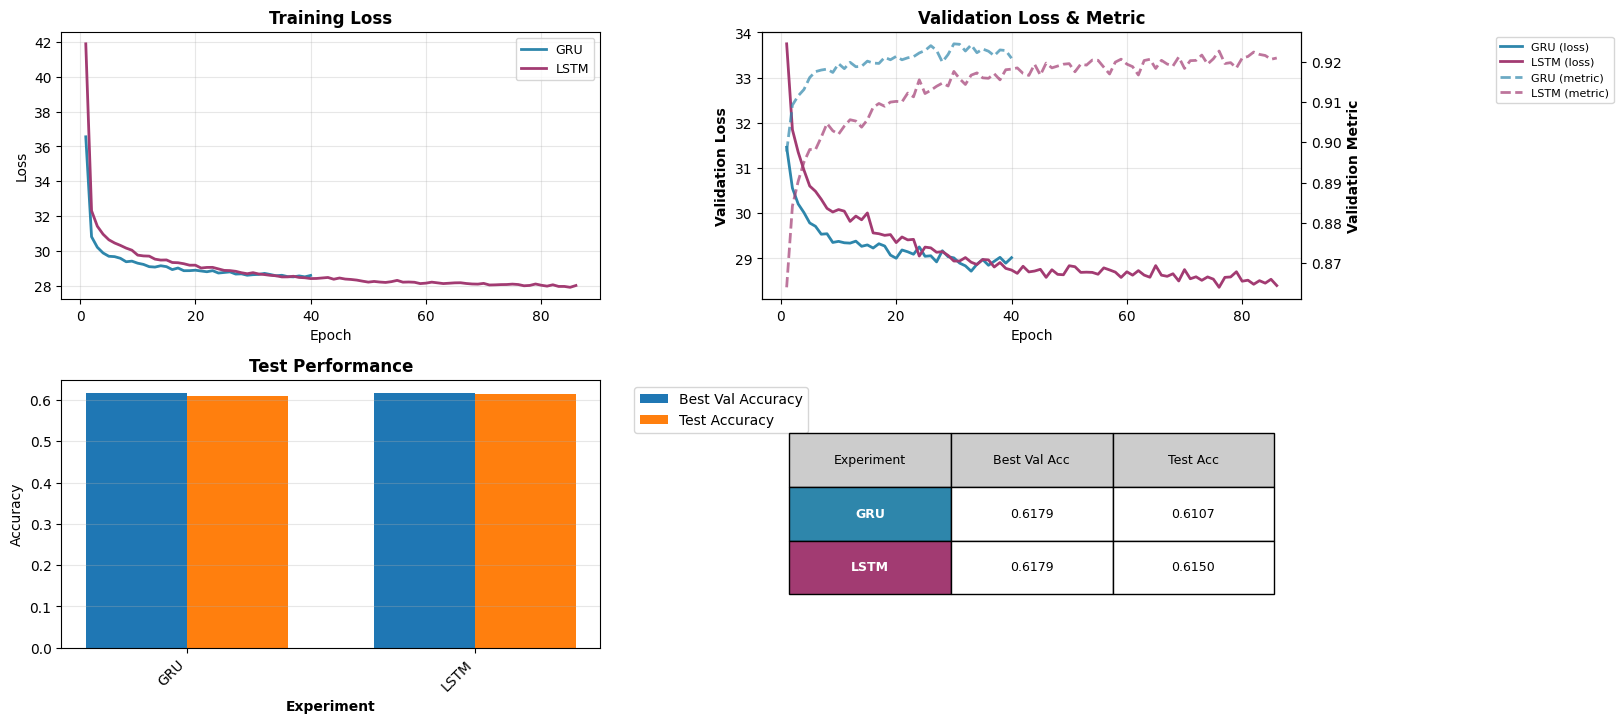

In [9]:
# Experiments config
experiments = {
    'GRU': ('results/gru_vs_lstm/gru', '#2E86AB'),
    'LSTM': ('results/gru_vs_lstm/lstm', '#A23B72'),
}
compare_experiments(experiments)

**Key Findings:**
- **LSTM demonstrates superior downstream task performance** compared to GRU, achieving higher accuracy on the final classification task
- **Training convergence**: LSTM converges notably slower than GRU, requiring more epochs to reach stable validation metrics
- **Trade-off**: While LSTM shows better final performance, practitioners should consider the increased training time when computational resources are limited

## Experiment 2: Backbone Hidden Dimension

**Objective:** Analyze the impact of hidden layer size on model performance.

This experiment compares various hidden dimension sizes in the GRU backbone to determine the optimal architecture capacity for the CoLES model.

/tmp/ipykernel_3948980/4149773246.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


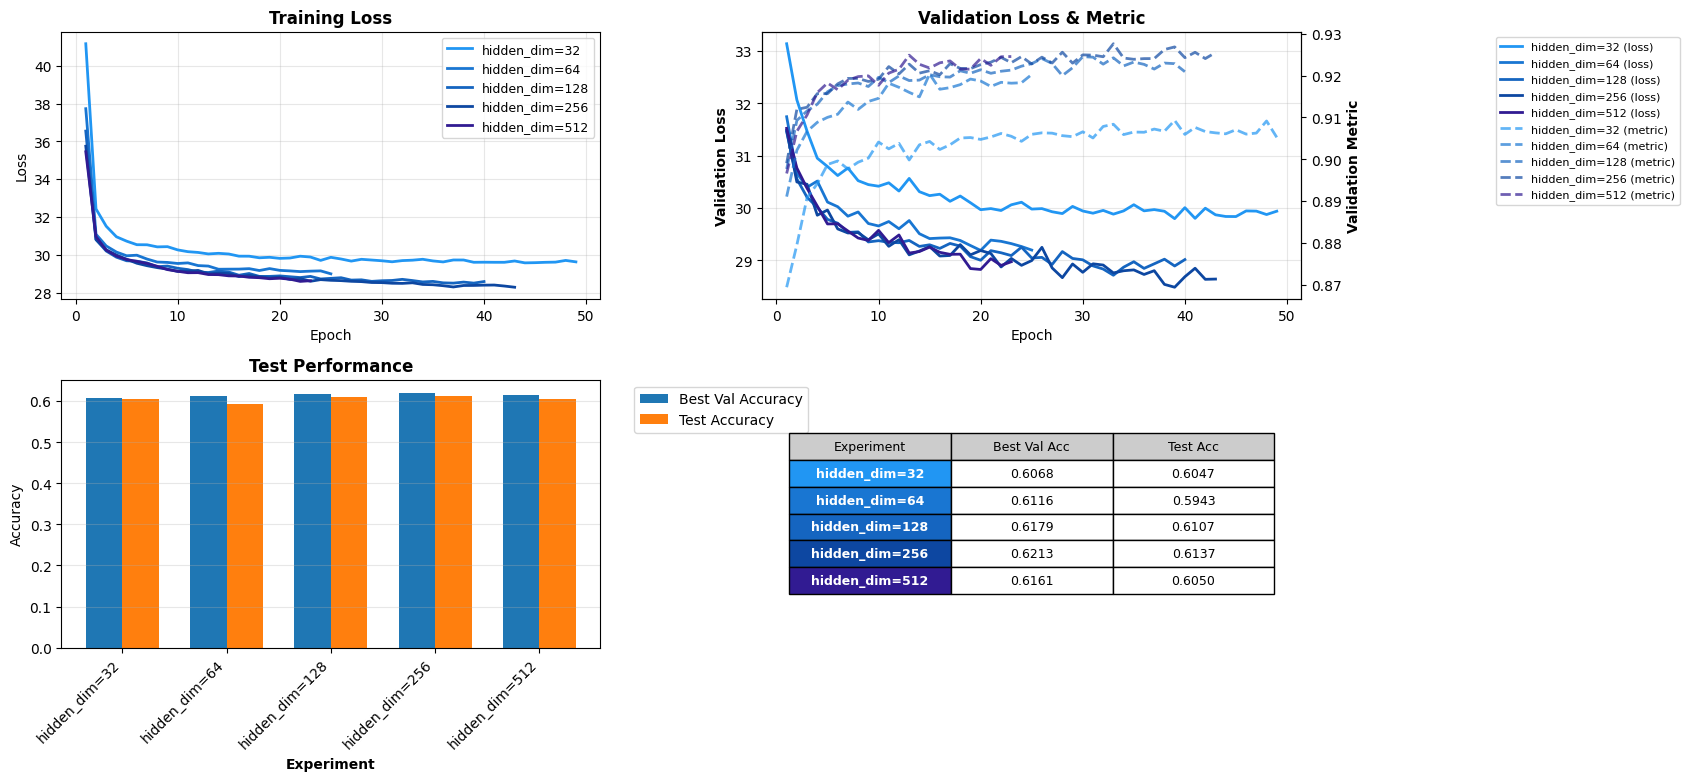

In [14]:
experiments = {
    'hidden_dim=32': ('results/compare_sizes/hidden_dim=32', '#2196F3'),
    'hidden_dim=64': ('results/compare_sizes/hidden_dim=64', '#1976D2'),
    'hidden_dim=128': ('results/compare_sizes/hidden_dim=128', '#1565C0'),
    'hidden_dim=256': ('results/compare_sizes/hidden_dim=256', '#0D47A1'),
    'hidden_dim=512': ('results/compare_sizes/hidden_dim=512', '#311B92')
}

compare_experiments(experiments)

**Key Findings:**
- **Hidden dimension has a substantial impact** on both validation metrics and loss values
- **Optimal configuration**: `hidden_dim=256` achieves the best results across both test accuracy and best validation accuracy
- **Performance trend**: Model performance exhibits a monotonic improvement as hidden dimension increases from 32 to 256, then plateaus or slightly degrades at 512
- **Recommendation**: For this dataset and task, `hidden_dim=256` provides the optimal balance between model capacity and generalization

## Experiment 3: Batch Size Impact

**Objective:** Investigate how batch size affects both training efficiency and model quality.

This experiment compares different batch sizes during training. Note that batch size has a unique impact in contrastive learning beyond standard training speed considerations:

- **Validation**: All experiments use the same batch size for fair metric comparison
- **Contrastive Loss**: Since negative samples are drawn from within each batch, batch size directly influences the contrastive loss computation and potentially affects model convergence and final performance

/tmp/ipykernel_3948980/4149773246.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


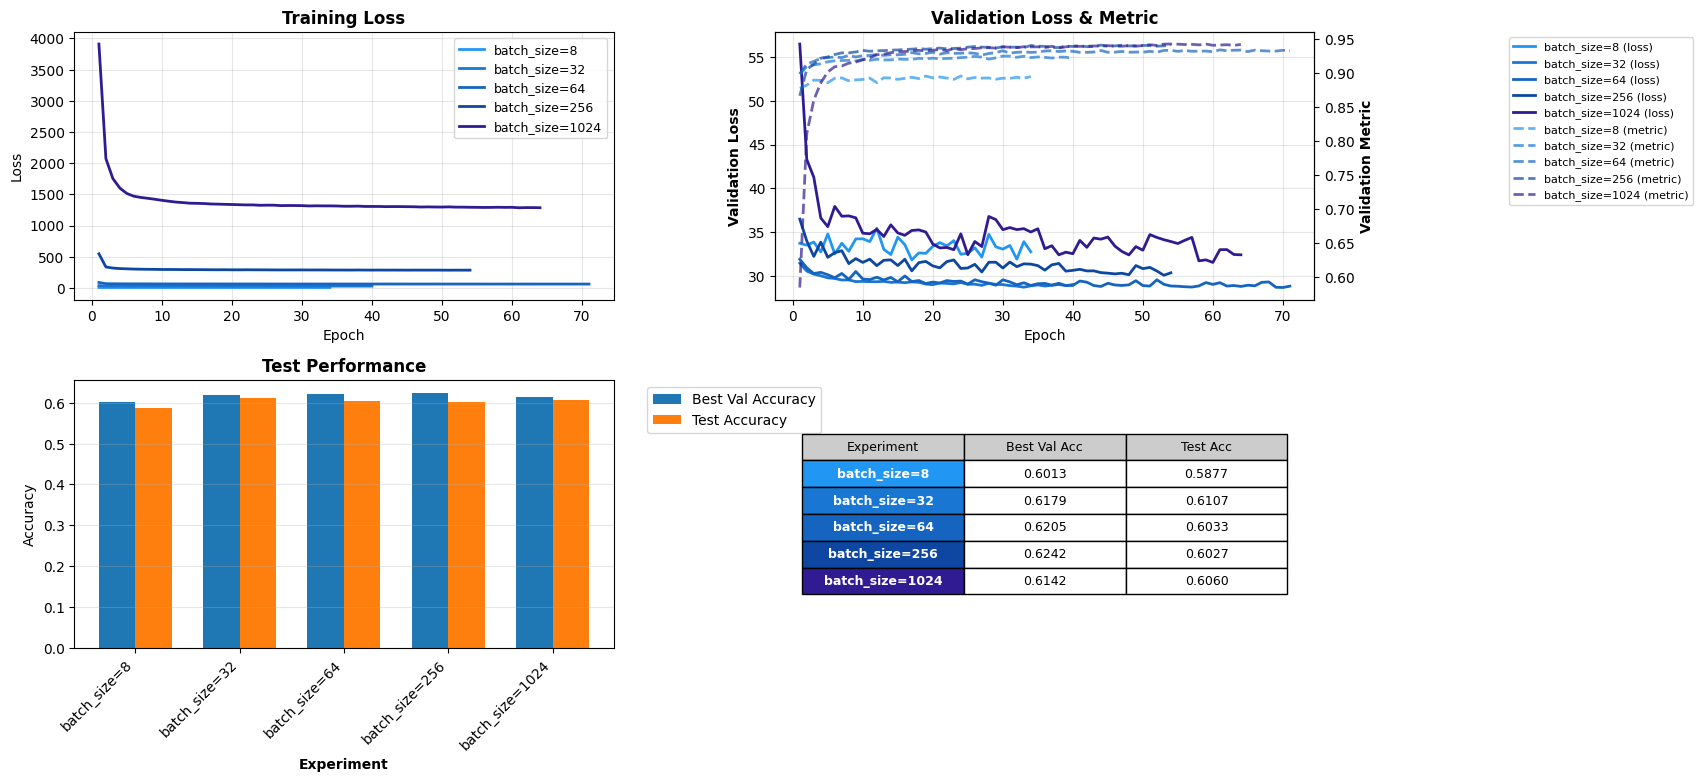

In [15]:
experiments = {
    'batch_size=8': ('results/compare_batch_size/batch_size=8', '#2196F3'),
    'batch_size=32': ('results/compare_batch_size/batch_size=32', '#1976D2'),
    'batch_size=64': ('results/compare_batch_size/batch_size=64', '#1565C0'),
    'batch_size=256': ('results/compare_batch_size/batch_size=256', '#0D47A1'),
    'batch_size=1024': ('results/compare_batch_size/batch_size=1024', '#311B92')
}

compare_experiments(experiments)

**Key Findings:**
- **Convergence behavior varies significantly** across different batch sizes, particularly evident in validation metric dynamics
- **Optimal batch size**: `batch_size=32` achieves the best performance, balancing two competing factors:
  - **Small batches** (e.g., 8, 16): Insufficient negative samples within each batch, limiting the effectiveness of contrastive learning
  - **Large batches** (e.g., 128, 256): Fewer gradient updates per epoch lead to unstable convergence and potential overfitting
- **Practical advantage**: The optimal `batch_size=32` is memory-efficient and can run on modest GPU hardware, making it accessible for researchers with limited computational resources
- **Contrastive learning insight**: This experiment confirms that batch size is a critical hyperparameter in contrastive learning frameworks, where it directly affects the quality and diversity of negative samples

**Recommendation**: Use `batch_size=32` as the default configuration for this task, as it provides both optimal performance and practical feasibility.

## Experiment 4: Embedding Dimension Sizes

**Objective:** Determine optimal embedding dimensions for high-cardinality categorical features.

In the age prediction dataset, `small_group` and `trans_date` are categorical columns with a large number of unique classes. This experiment explores different embedding dimension sizes for these features to balance expressiveness and model complexity.

/tmp/ipykernel_3948980/4149773246.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


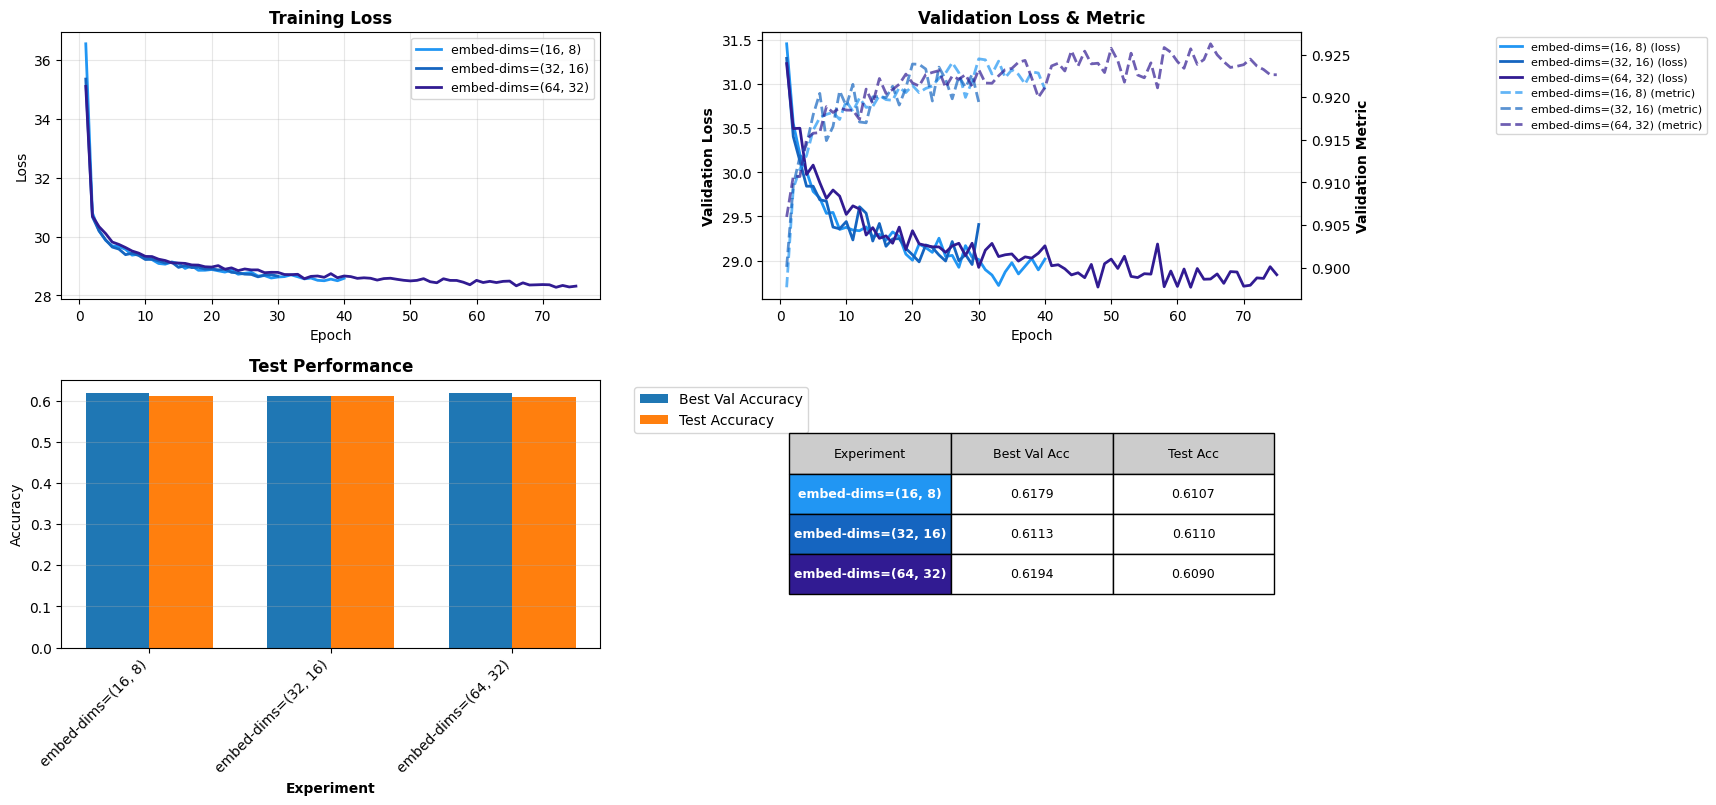

In [16]:
experiments = {
    'embed-dims=(16, 8)': ('results/compare-embed-dims/16-8', '#2196F3'),
    'embed-dims=(32, 16)': ('results/compare-embed-dims/32-16', '#1565C0'),
    'embed-dims=(64, 32)': ('results/compare-embed-dims/64-32', '#311B92')
}

compare_experiments(experiments)


**Key Findings:**
- **Minimal downstream impact**: Different embedding dimensions for high-cardinality categorical features (`small_group`, `trans_date`) show negligible differences in final test accuracy
- **Contrastive training phase observations**:
  - **Smaller embeddings** (e.g., 8, 16): Converge faster but plateau at higher contrastive loss and lower validation `recall_top_k` metrics
  - **Larger embeddings** (e.g., 32, 64): Require more training time but achieve better contrastive loss and validation metrics during pre-training
- **Performance-efficiency trade-off**: While larger embeddings show better internal representation quality during contrastive learning, this advantage does not translate significantly to downstream task performance